# Accidental Drug-related Deaths in Connecticut Analysis

This notebook is the first of a series of various data analyses in which I try to better understand the United States' opioid epidemic. For background on this public health crisis: https://www.hhs.gov/opioids/about-the-epidemic/

The first dataset I will examine is the State of Connectcut's "Accidental Drug Related Deaths 2012-2016" https://catalog.data.gov/dataset/accidental-drug-related-deaths-january-2012-sept-2015 

The corresponding csv file can be found in the directory.

In [27]:
#first, let's load the data and see its structure
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import axes
from datetime import *
import shapefile
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import shapefile
from array import array
from IPython.display import SVG, display
dataframe = pd.read_csv('Accidental_Drug_Related_Deaths__2012-2016.csv')

In [3]:
print(dataframe.shape)

(3045, 32)


In [4]:
#let's see what the headers look like 
print(dataframe.columns)

Index(['CaseNumber', 'Date', 'Sex', 'Race', 'Age', 'Residence City',
       'Residence State', 'Residence County', 'Death City', 'Death State',
       'Death County', 'Location', 'DescriptionofInjury', 'InjuryPlace',
       'ImmediateCauseA', 'Heroin', 'Cocaine', 'Fentanyl', 'Oxycodone',
       'Oxymorphone', 'EtOH', 'Hydro-codeine', 'Benzodiazepine', 'Methadone',
       'Amphet', 'Tramad', 'Morphine (not heroin)', 'Other', 'Any Opioid',
       'MannerofDeath', 'AmendedMannerofDeath', 'DeathLoc'],
      dtype='object')


As we see, there are a lot of different angles from which we can appraoch this data. Both the spatial and temporal elements can help provide more insight into how the epidemic is affecting the state of Connecticut. 

In [5]:
#from a high level, let's first see how the number of heroin-related deaths has changed over the course of the 4 years. 
#we can construct dataframes for each year and save them for later use

#converting the date column into a more readable format 
#for date in dataframe['Date']: 
 #   print(date)

df_2012 = dataframe[dataframe['Date'].str.contains('2012')==True]
df_2013 = dataframe[dataframe['Date'].str.contains('2013')==True]
df_2014 = dataframe[dataframe['Date'].str.contains('2014')==True]
df_2015 = dataframe[dataframe['Date'].str.contains('2015')==True]
df_2016 = dataframe[dataframe['Date'].str.contains('2016')==True]



In [6]:
#We see 1652 heroin-related deaths in the entire dataset
print(dataframe['Heroin'].value_counts()['Y'])


1652


In [7]:
#Let's dig further into how many heroin-related deaths have occured on a year-by-year basis. 


print("Year\tHeroin-Related Deaths")
print("2012\t"+str(df_2012['Heroin'].value_counts()['Y']))
print("2013\t"+str(df_2013['Heroin'].value_counts()['Y']))
print("2014\t"+str(df_2014['Heroin'].value_counts()['Y']))
print("2015\t"+str(df_2015['Heroin'].value_counts()['Y']))
print("2016\t"+str(df_2016['Heroin'].value_counts()['Y']))


Year	Heroin-Related Deaths
2012	174
2013	256
2014	325
2015	415
2016	482


As we can see, the number of heroin-related deaths in the state of Connecticut has increased steadily in the past four years. We can use this as a baseline to dig deeper. 

Let's now try to visualize the given data geospatially. We can use external Census data to construct a heatmap of the state of Connecticut colored by the number of heroin-related deaths at the zip-code level. We can then see how this evolves year-to-year. 

For this, we can use a zip-code database: http://federalgovernmentzipcodes.us/

In [8]:
#Load the data 
zip_codes = pd.read_csv('free-zipcode-database.csv', dtype = {"RecordNumber": int, "Zipcode": str}, low_memory=False)

In [9]:
#pull the zip codes for CT only 
zip_codes_ct = zip_codes[zip_codes['State'].str.contains('CT') == True]
#throw out the rest of the data
zip_codes_ct = zip_codes_ct[['Zipcode', 'City']]

#joining the data on the city name to obtain the zip code for each city
#note: this isn't wholly accurate since one city may have multiple zip codes, but we will ignore this for simplicity
dataframe_zip = pd.merge(dataframe, 
                zip_codes_ct.drop_duplicates('City'), left_on='Death City', right_on='City', 
                how='left')

In [10]:
#as it turns out, GIS is more involved than I initially thought. I will come back to creating the map
#We can at least see which cities have had the greatest number of heroin-related deaths

df = dataframe_zip.groupby('Zipcode').count()
print(df[['Heroin']].sort_values('Heroin', ascending=False)[0:5])



         Heroin
Zipcode        
06101       199
06501       125
06701       121
06601       110
06050        79


With high-level temporal and geospatial understanding of the data, let's dig into some demographic features. The main demographic indicators we have are sex, age, and race. 

With sex, we can see if there are any significant differences between male and female in terms of heroin-related deaths.

In [11]:
dataframe_male = dataframe[dataframe['Sex'].str.contains('Male')==True]
dataframe_female = dataframe[dataframe['Sex'].str.contains('Female')==True]

In [12]:
print("Male Heroin-related Deaths:\t" + str(dataframe_male['Heroin'].value_counts()['Y']))
print("Female Heroin-related Deaths:\t" + str(dataframe_female['Heroin'].value_counts()['Y']))

Male Heroin-related Deaths:	1295
Female Heroin-related Deaths:	357


As we can see, there is a significantly higher number of male heroin-related deaths than female. We can plot the time-series for each sex.

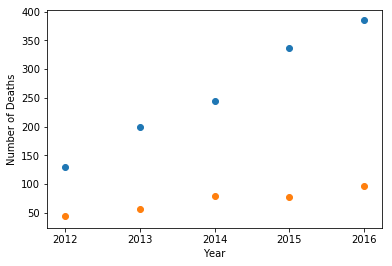

In [13]:
years = [2012, 2013, 2014, 2015, 2016]
#dataframes by year male
df_2012_male = dataframe_male[dataframe_male['Date'].str.contains('2012')==True]
df_2013_male = dataframe_male[dataframe_male['Date'].str.contains('2013')==True]
df_2014_male = dataframe_male[dataframe_male['Date'].str.contains('2014')==True]
df_2015_male = dataframe_male[dataframe_male['Date'].str.contains('2015')==True]
df_2016_male = dataframe_male[dataframe_male['Date'].str.contains('2016')==True]
deaths_by_year_male = [df_2012_male['Heroin'].value_counts()['Y'], df_2013_male['Heroin'].value_counts()['Y'], 
                       df_2014_male['Heroin'].value_counts()['Y'], df_2015_male['Heroin'].value_counts()['Y'],
                      df_2016_male['Heroin'].value_counts()['Y']]

#dataframes by year female 
df_2012_female = dataframe_female[dataframe_female['Date'].str.contains('2012')==True]
df_2013_female = dataframe_female[dataframe_female['Date'].str.contains('2013')==True]
df_2014_female = dataframe_female[dataframe_female['Date'].str.contains('2014')==True]
df_2015_female = dataframe_female[dataframe_female['Date'].str.contains('2015')==True]
df_2016_female = dataframe_female[dataframe_female['Date'].str.contains('2016')==True]
deaths_by_year_female = [df_2012_female['Heroin'].value_counts()['Y'], df_2013_female['Heroin'].value_counts()['Y'], 
                       df_2014_female['Heroin'].value_counts()['Y'], df_2015_female['Heroin'].value_counts()['Y'],
                      df_2016_female['Heroin'].value_counts()['Y']]

#plot 
plt.scatter(years, deaths_by_year_male)
plt.scatter(years, deaths_by_year_female)
plt.xlabel('Year')
plt.ylabel('Number of Deaths')
plt.xticks(years, years)
plt.show()


Interestingly the number of male heroin-related deaths increases steadily every year, while the number of female heroin-related deaths stays relatively stable. Let's investigate the distribution of deaths by age. 

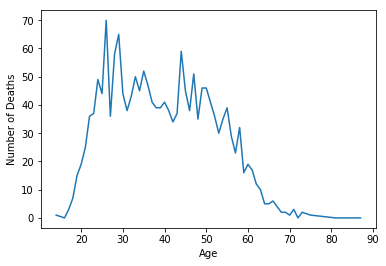

In [14]:
#Group by age and count instances 
df = dataframe.groupby('Age').count()
plt.plot(df['Heroin'])
plt.xlabel("Age")
plt.ylabel("Number of Deaths")
plt.show()


Since age is our only (sort of) continuous variable, let's run a simple logistic regression to see whether age is correlated with heroin death. 

In [15]:
#extract relevant data 
df_logistic = dataframe[['Age','Heroin']]

#clean data 
clean_values = []
for val in df_logistic['Heroin'].iteritems():
    if(val[1] is'Y'):
        clean_values.append(1)
    else:
        clean_values.append(0)
        
se = pd.Series(clean_values)
pd.options.mode.chained_assignment = None
df_logistic['Heroin_values'] = se.values
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
x_vals = df_logistic['Age'].values.reshape(1,-1)
y_vals = df_logistic['Heroin_values'].values.reshape(1,-1)

# check the accuracy on the training set
x_vals = x_vals[0]
y_vals = y_vals[0]

#remove two nan
x_vals = np.delete(x_vals, 981)
y_vals = np.delete(y_vals, 981)
x_vals = np.delete(x_vals, 1909)
y_vals = np.delete(y_vals, 1909)

#run logistic regression on training data (i.e. whole dataset)
model = model.fit(x_vals.reshape(-1,1), y_vals.reshape(-1,1).ravel())

# check the accuracy on the training set
print(model.score(x_vals.reshape(-1,1), y_vals.reshape(-1,1).ravel()))







0.598751232337


As we can see, the accuracy of the model on the training data is around 60%. The regression isn't great, but we can see how good of a predictor age is of heroin-related death nonetheless as an exercise.

In [16]:
#split the data into test and training sets 
X_train, X_test, y_train, y_test = train_test_split(x_vals.reshape(-1,1), y_vals.reshape(-1,1).ravel(), 
                                                    test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
#predict the labels for the X values test set 
predicted = model2.predict(X_test)

#probabilities 
probs = model2.predict_proba(X_test)

#finally, we can evaluate how our logistic regression model performed on the test data
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.614457831325
0.639210832848


As we see, the accuracy of this model is slightly better than that predicted with the test data.

In this notebook, I performed basic data analysis, cleaning, and statistics on a public health dataset.
I hope to expand on this data in future notebooks.

**Update** : I will attempt to plot here a heatmap of the number of deaths per county. First let's aggregate the data we need...

In [18]:
df_county = dataframe.groupby('Death County').count()['Heroin']
#let's make a value map from this data for easier processing
values = {}
for val in df_county.keys():
    values[val] = df_county[val]

print(values)


{'FAIRFIELD': 210, 'HARTFORD': 417, 'LITCHFIELD': 86, 'MIDDLESEX': 62, 'NEW HAVEN': 366, 'NEW LONDON': 154, 'TOLLAND': 37, 'USA': 0, 'WINDHAM': 54}


So apparently this is really annoying to do in matplotlib so I'm going to write this to a CSV and make the map in R. Stay tuned.

In [19]:
df_county.to_csv('county_data.csv')

**Update** : I finally made the map in R! Here is a screenshot of the output. If you want to see the code I used to generate the choropleth map, see the attached .Rmd file in the repository. 

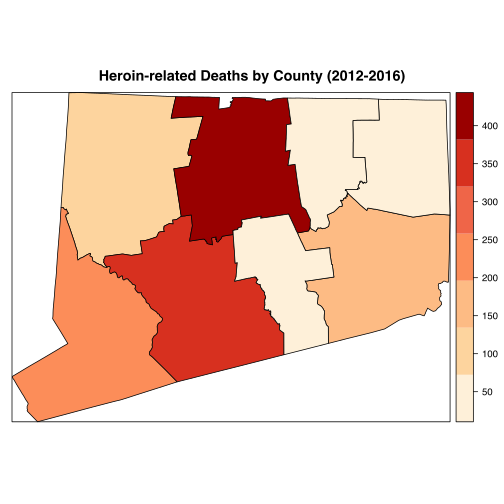

In [28]:
SVG('map.svg')